In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Общее количество аннотаций в обучающем наборе: 5615
Общее количество аннотаций в валидационном наборе: 823
   class_id  x_center  y_center     width    height  \
0         0  0.381250  0.460938  0.117969  0.275781   
1         0  0.588281  0.667969  0.311719  0.425000   
2         0  0.867969  0.253125  0.103906  0.223438   
3         0  0.667188  0.220312  0.076563  0.255469   
4         0  0.720313  0.276562  0.068750  0.176563   

                                            filename  
0  20410533613_56da1cce7c_jpg.rf.9087c4eb85c02a3f...  
1  20410533613_56da1cce7c_jpg.rf.9087c4eb85c02a3f...  
2  20410533613_56da1cce7c_jpg.rf.9087c4eb85c02a3f...  
3  20410533613_56da1cce7c_jpg.rf.9087c4eb85c02a3f...  
4  20410533613_56da1cce7c_jpg.rf.9087c4eb85c02a3f...  
Index(['class_id', 'x_center', 'y_center', 'width', 'height', 'filename'], dtype='object')


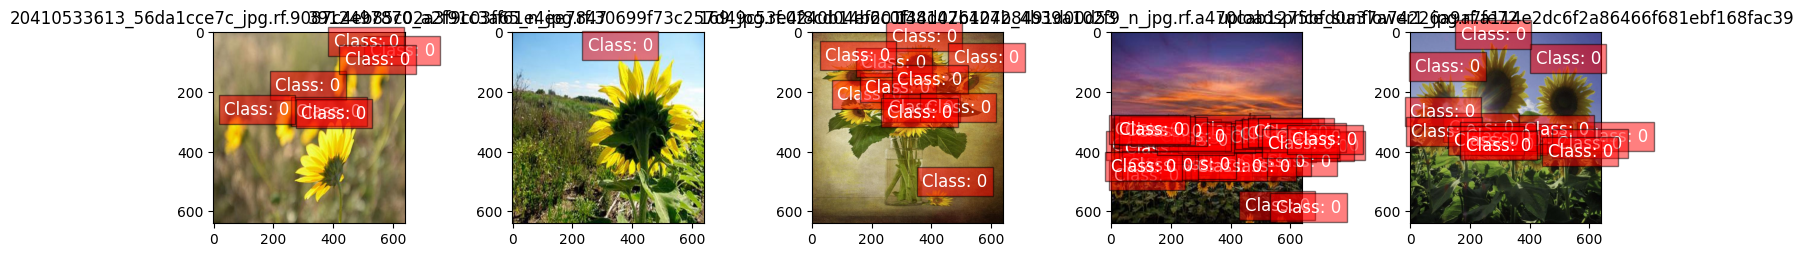

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

def load_annotations(labels_dir):
    data = []
    for label_file in os.listdir(labels_dir):
        if label_file.endswith('.txt'):
            with open(os.path.join(labels_dir, label_file), 'r') as f:
                lines = f.readlines()
                for line in lines:
                    values = line.strip().split()
                    if len(values) == 5:
                        class_id, x_center, y_center, width, height = map(float, values)
                        data.append({'class_id': int(class_id),
                                      'x_center': x_center,
                                      'y_center': y_center,
                                      'width': width,
                                      'height': height,
                                      'filename': label_file[:-4]})
    return pd.DataFrame(data)

# Загрузка аннотаций
train_labels_dir = '/content/gdrive/MyDrive/sunflowers_dataset/train/labels'
valid_labels_dir = '/content/gdrive/MyDrive/sunflowers_dataset/valid/labels'

train_annotations = load_annotations(train_labels_dir)
valid_annotations = load_annotations(valid_labels_dir)

print(f'Общее количество аннотаций в обучающем наборе: {len(train_annotations)}')
print(f'Общее количество аннотаций в валидационном наборе: {len(valid_annotations)}')

# plt.figure(figsize=(10, 5))
# sns.countplot(data=train_annotations, x='class_id')
# plt.title('Распределение классов в обучающем наборе')
# plt.xlabel('Идентификатор класса')
# plt.ylabel('Количество аннотаций')
# plt.show()

print(train_annotations.head())
print(train_annotations.columns)

def visualize_images_with_annotations(images_dir, annotations_df, num_images=5):
    sample_files = annotations_df['filename'].unique()[:num_images]

    plt.figure(figsize=(15, 10))

    for i, file in enumerate(sample_files):
        img_path = os.path.join(images_dir, file + '.jpg')
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.title(file)

        # Отображение аннотаций
        for _, row in annotations_df[annotations_df['filename'] == file].iterrows():
            x_center = row['x_center'] * image.shape[1]
            y_center = row['y_center'] * image.shape[0]
            width = row['width'] * image.shape[1]
            height = row['height'] * image.shape[0]
            x_min = int(x_center - width / 2)
            y_min = int(y_center - height / 2)
            x_max = int(x_center + width / 2)
            y_max = int(y_center + height / 2)

            # Рисуем прямоугольник с аннотацией
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)

            # Добавляем текст с классом
            plt.text(x_min, y_min - 10, f'Class: {row["class_id"]}', color='white', fontsize=12,
                     bbox=dict(facecolor='red', alpha=0.5))

    plt.tight_layout()  # Убираем наложение
    plt.show()

# Визуализация изображений с аннотациями
images_dir = '/content/gdrive/MyDrive/sunflowers_dataset/train/images'
visualize_images_with_annotations(images_dir, train_annotations)







Устанавливаем YOLO

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 874.8/874.8 kB 21.1 MB/s eta 0:00:00


Запускаем обучение

In [7]:
from ultralytics import YOLO

# Загрузка модели
model = YOLO('yolov8n.pt')

# Обучение модели с аугментацией
results = model.train(
    data='/content/gdrive/MyDrive/sunflowers_dataset/data.yaml',
    epochs=35,
    imgsz=640,
    #augment=True  # Используем предустановленную аугментацию
)

Ultralytics YOLOv8.2.102 🚀 Python-3.10.12 torch-2.4.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/gdrive/MyDrive/sunflowers_dataset/data.yaml, epochs=35, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=Tr

train: Scanning /content/gdrive/MyDrive/sunflowers_dataset/train/labels.cache... 480 images, 0 backgrounds, 0 corrupt: 100%|██████████| 480/480 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/gdrive/MyDrive/sunflowers_dataset/valid/labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]

Plotting labels to runs/detect/train2/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train2
Starting training for 35 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/35         0G      1.958      3.182      1.731        195        640:   7%|▋         | 2/30 [00:44<10:26, 22.39s/it]


KeyboardInterrupt: 

Графики метрик

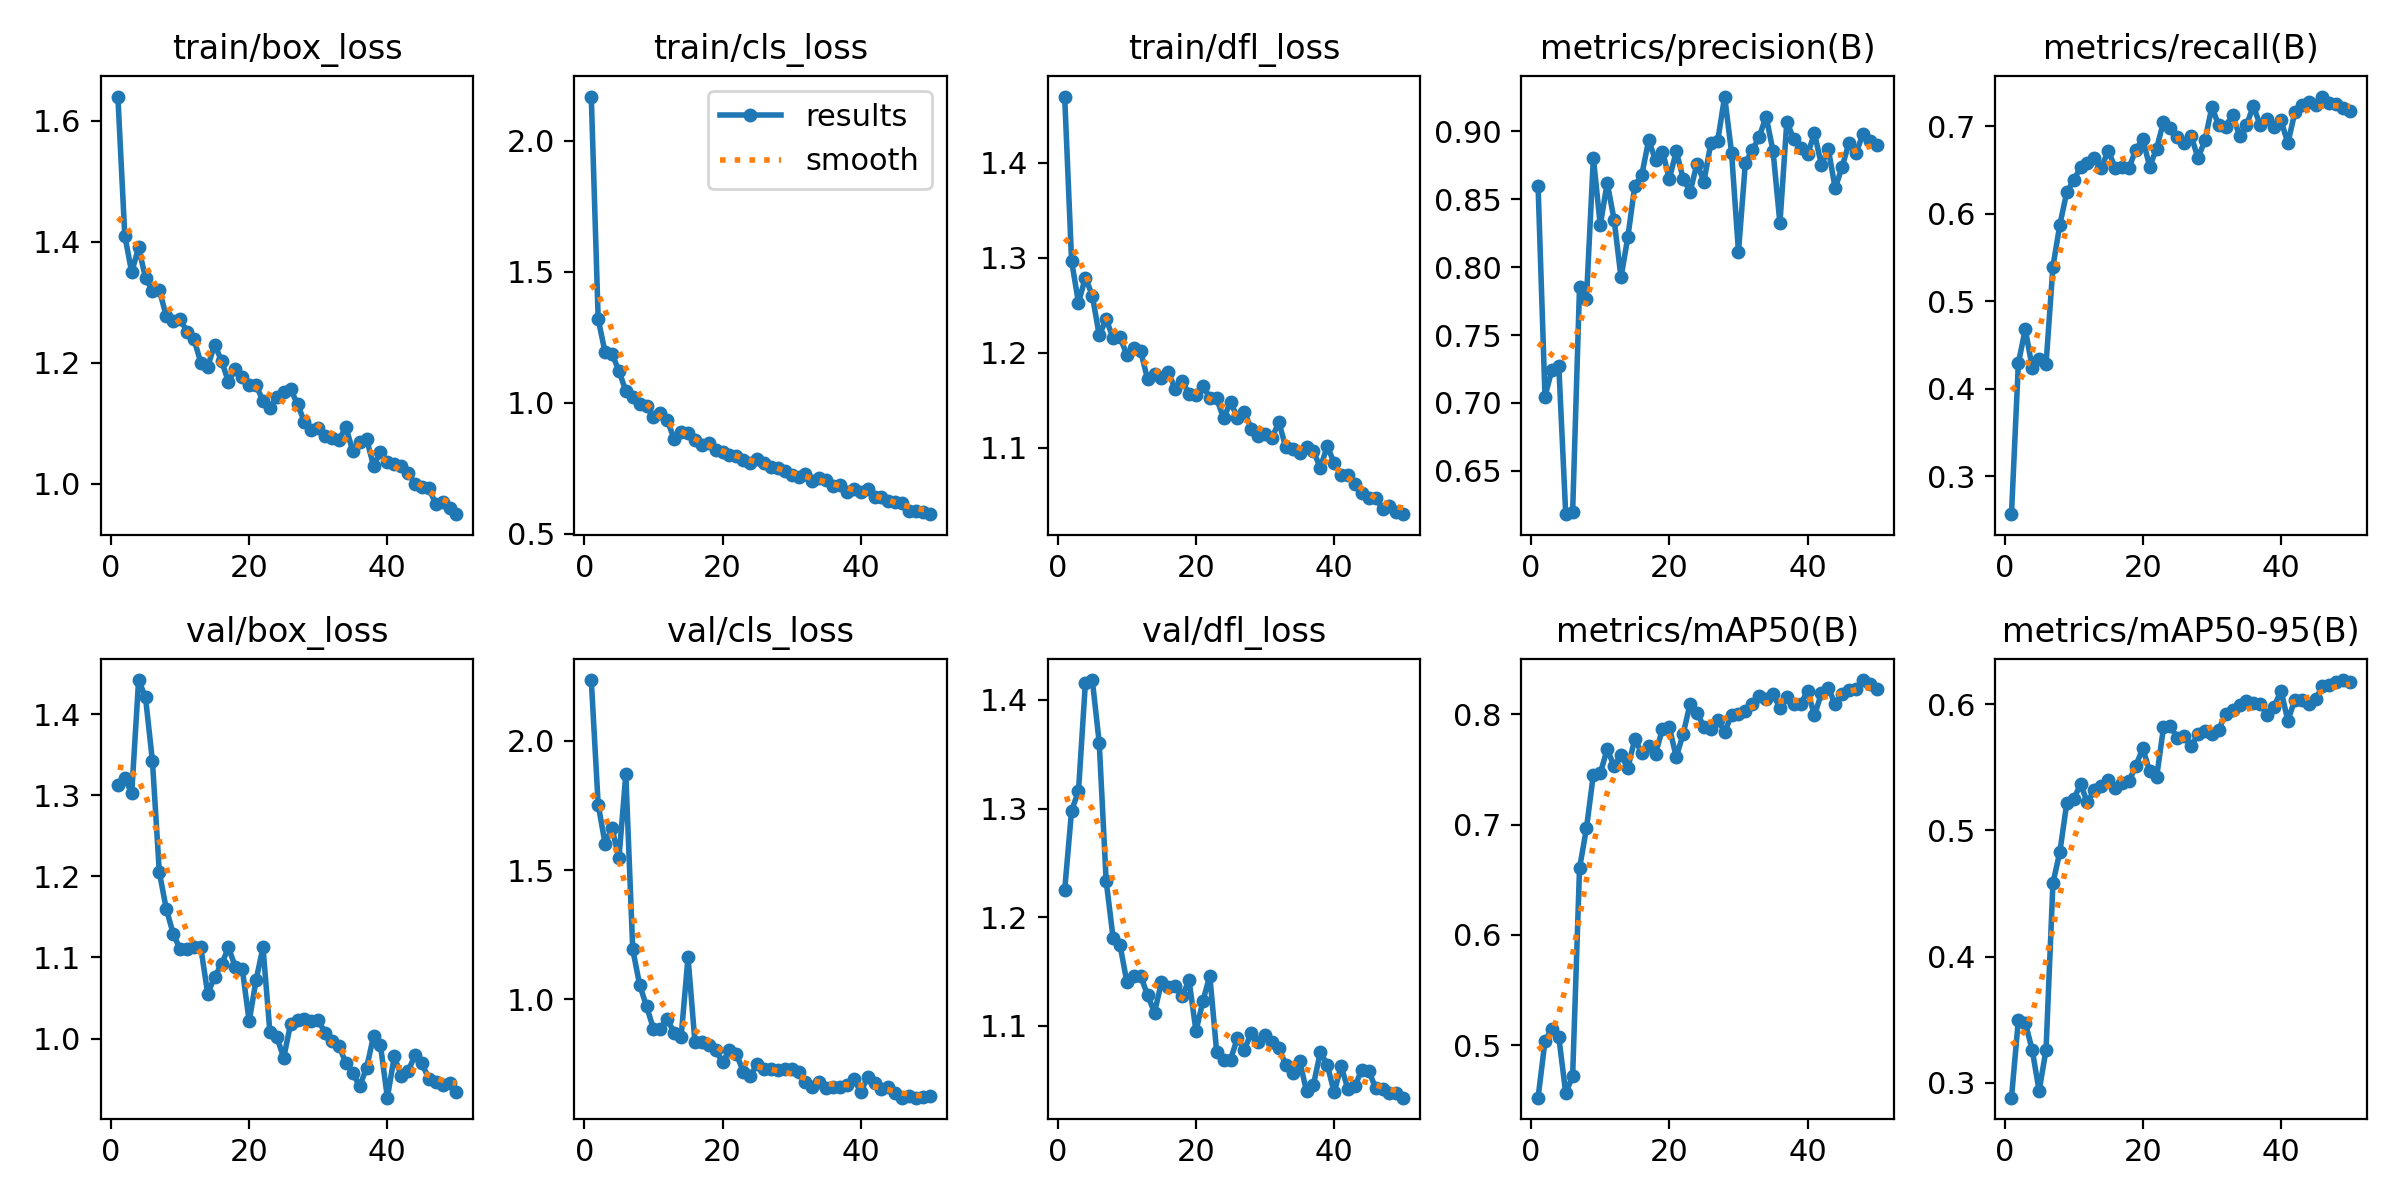

In [ ]:
from IPython.display import Image

Image(filename=f"/content/runs/detect/train4/results.png", width=1000)

Матрица несоответствий

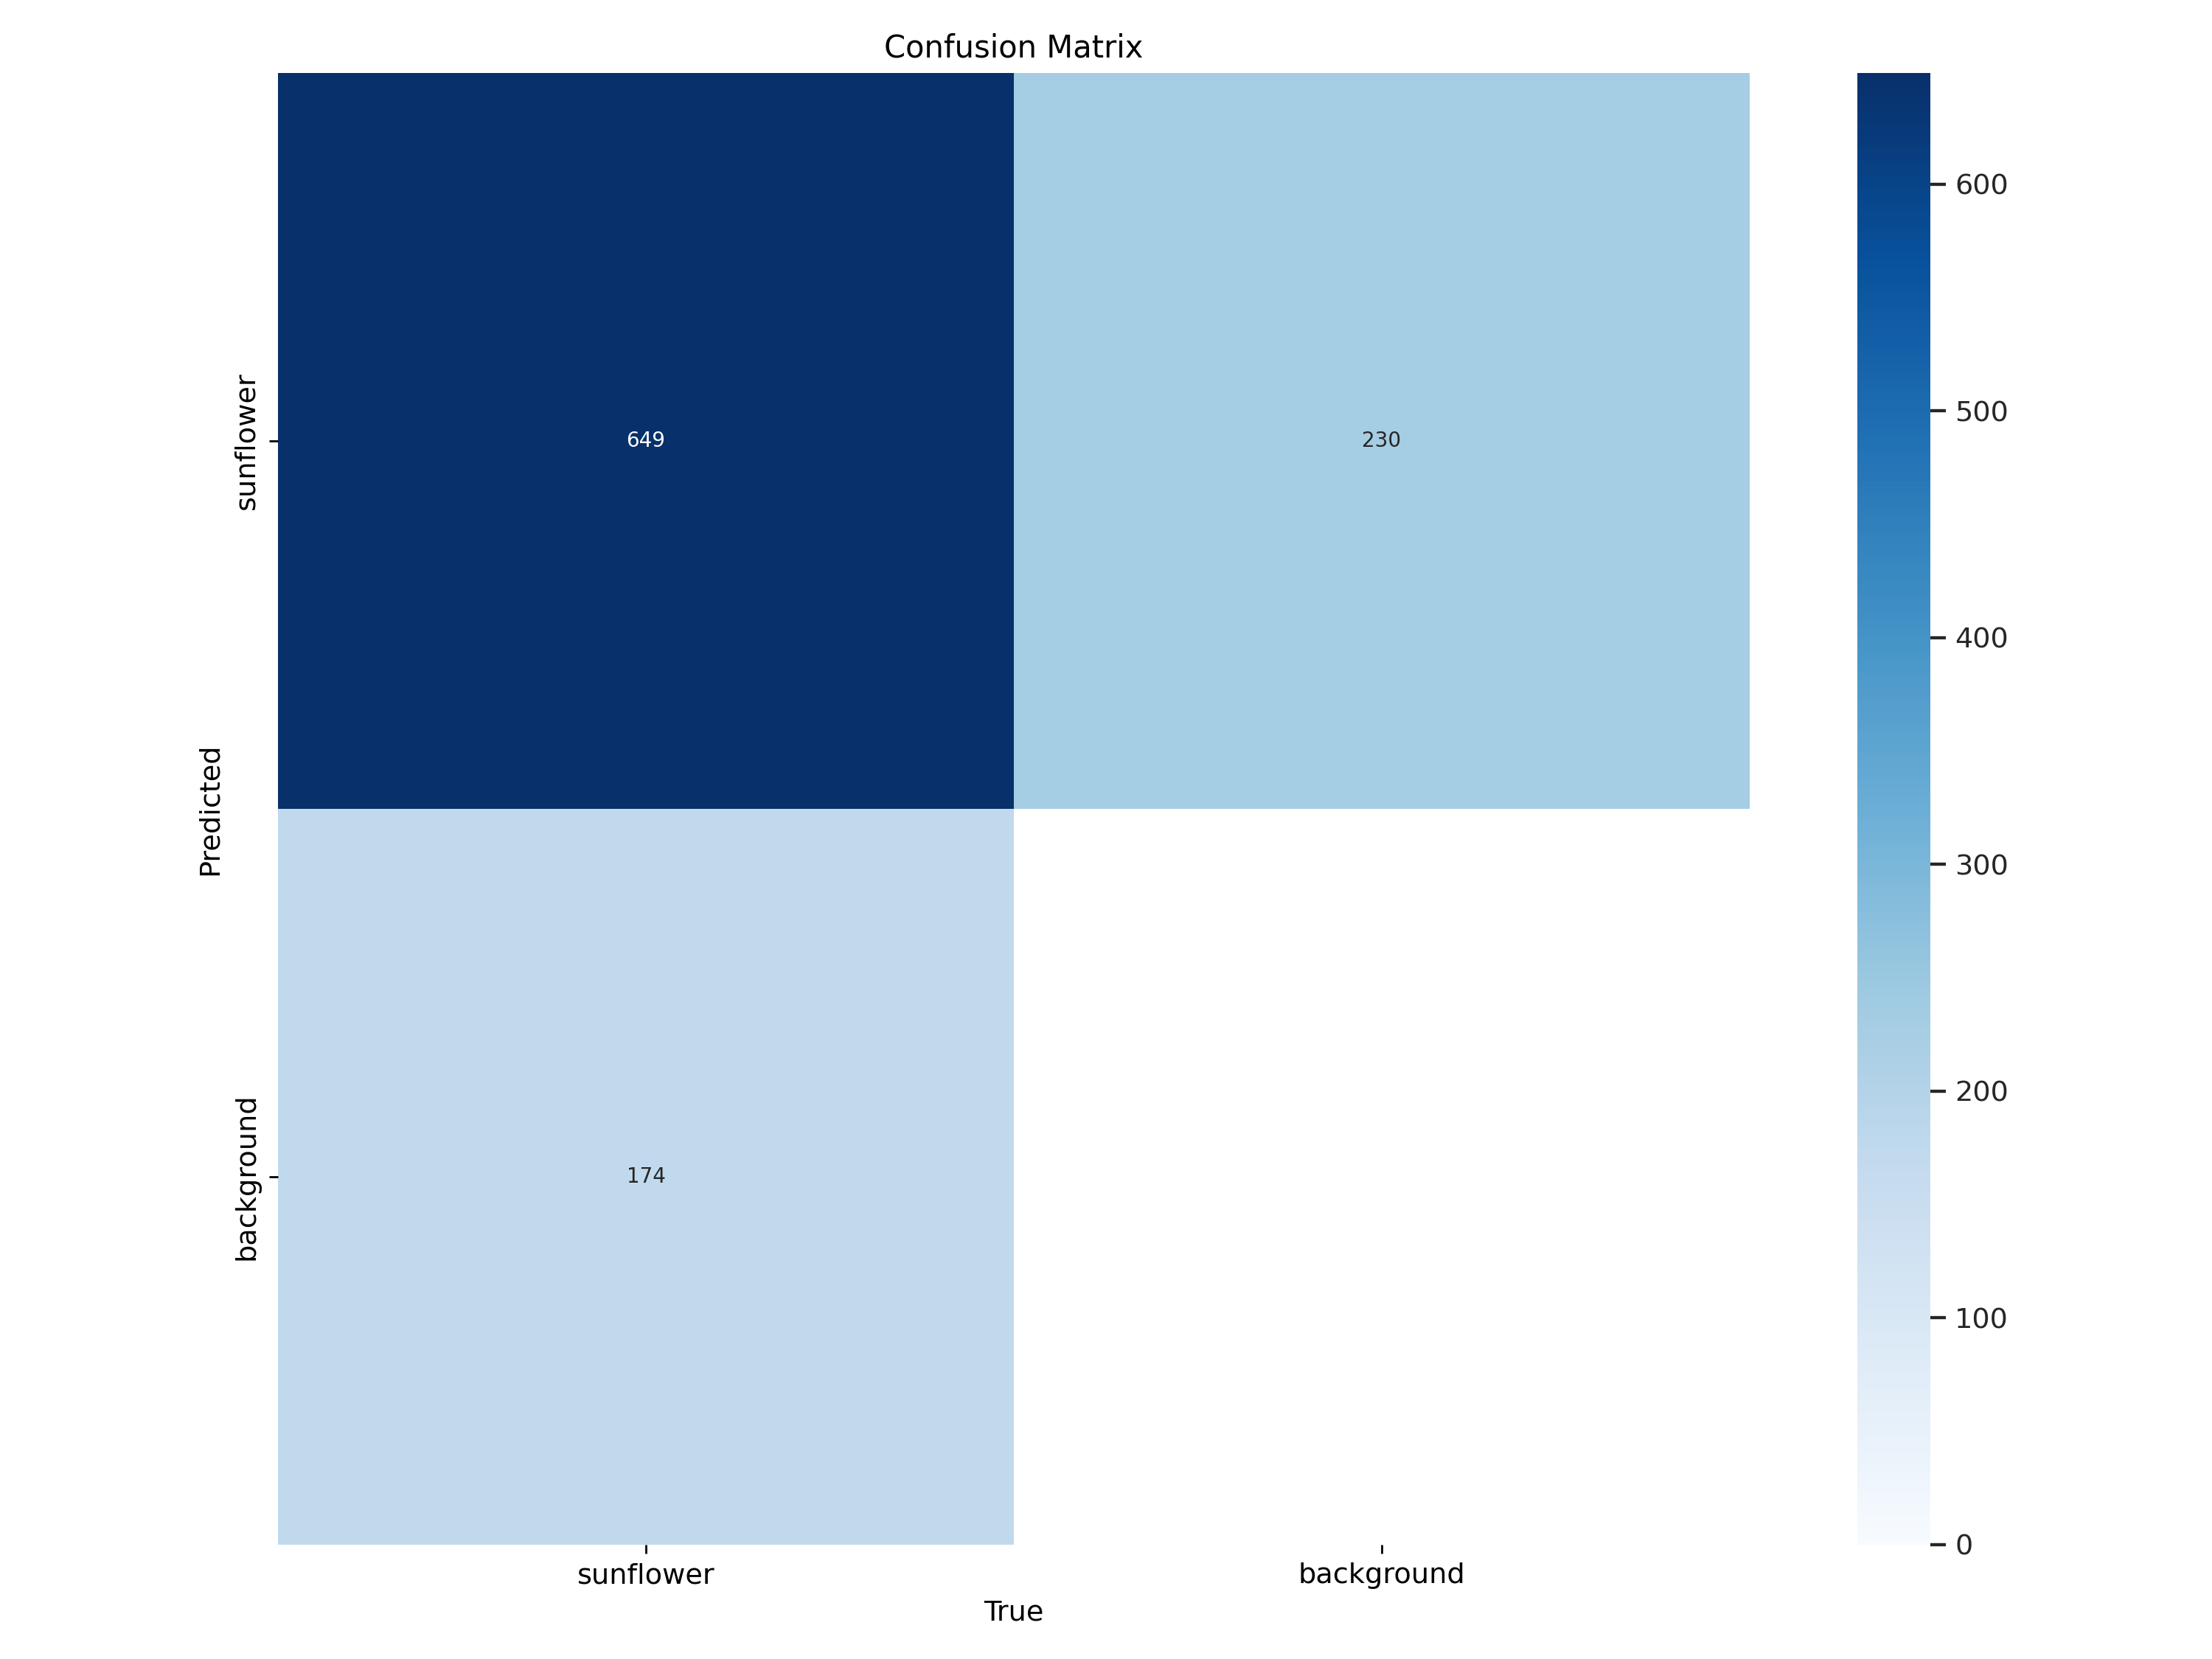

In [ ]:
from IPython.display import Image

Image(filename=f"/content/runs/detect/train4/confusion_matrix.png", width=1000)

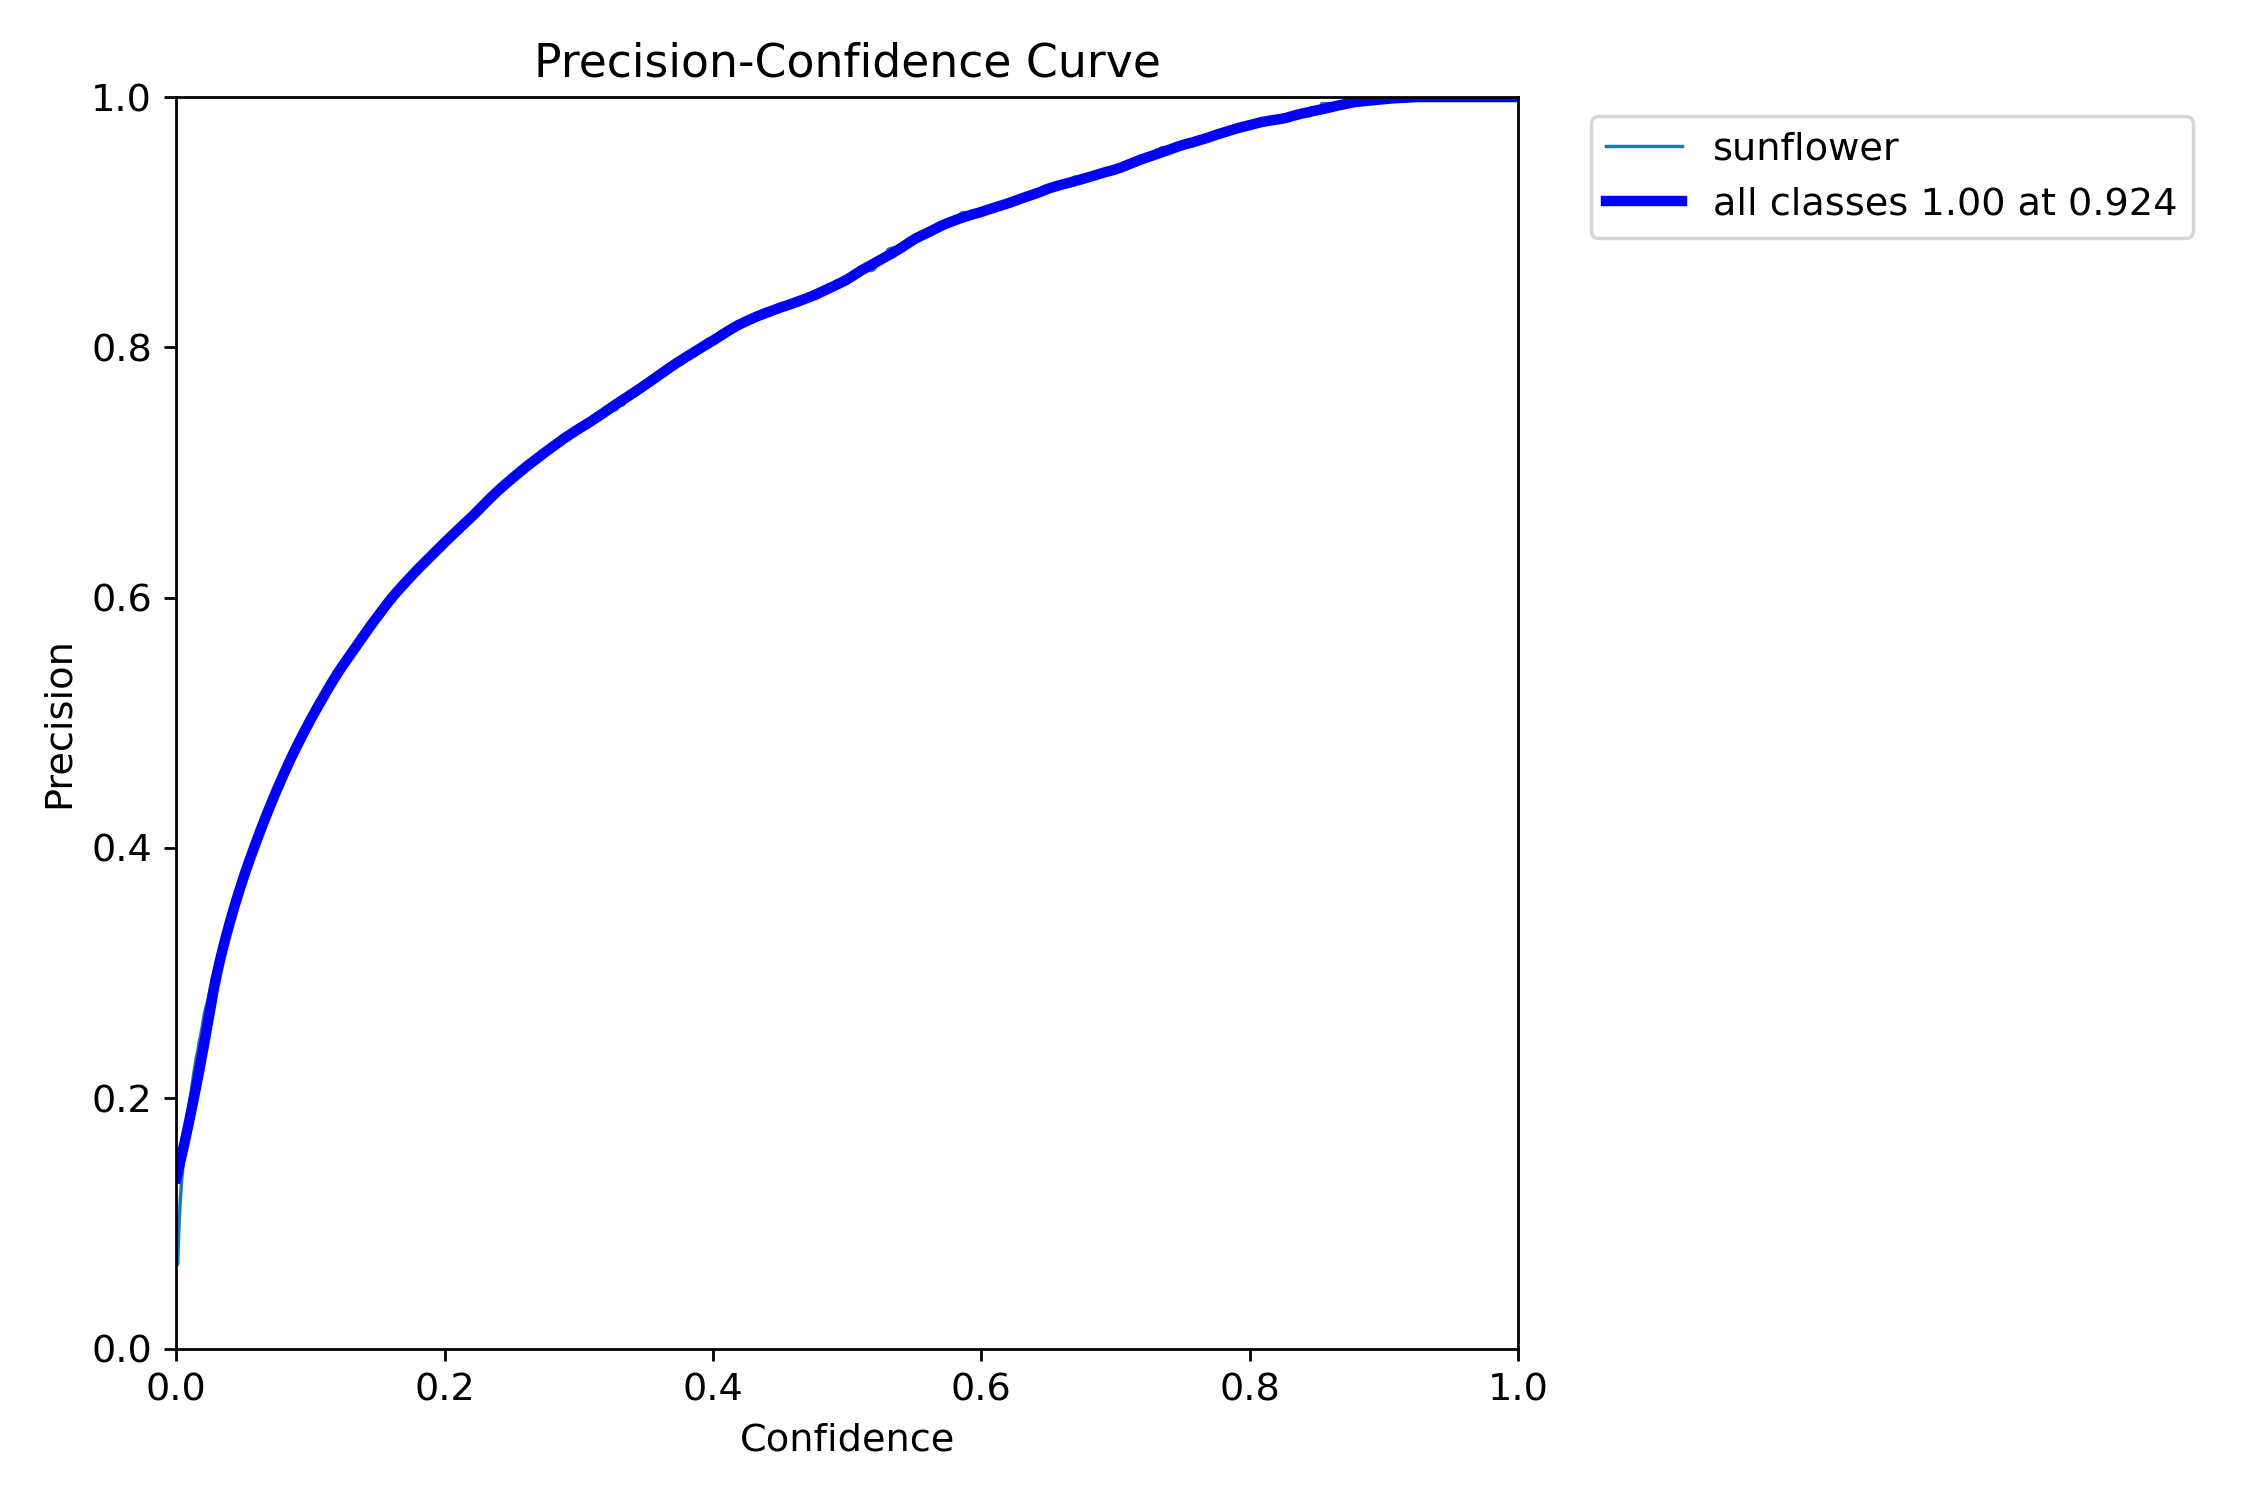

In [ ]:
from IPython.display import Image

Image(filename=f"/content/runs/detect/train5/P_curve.png", width=1000)

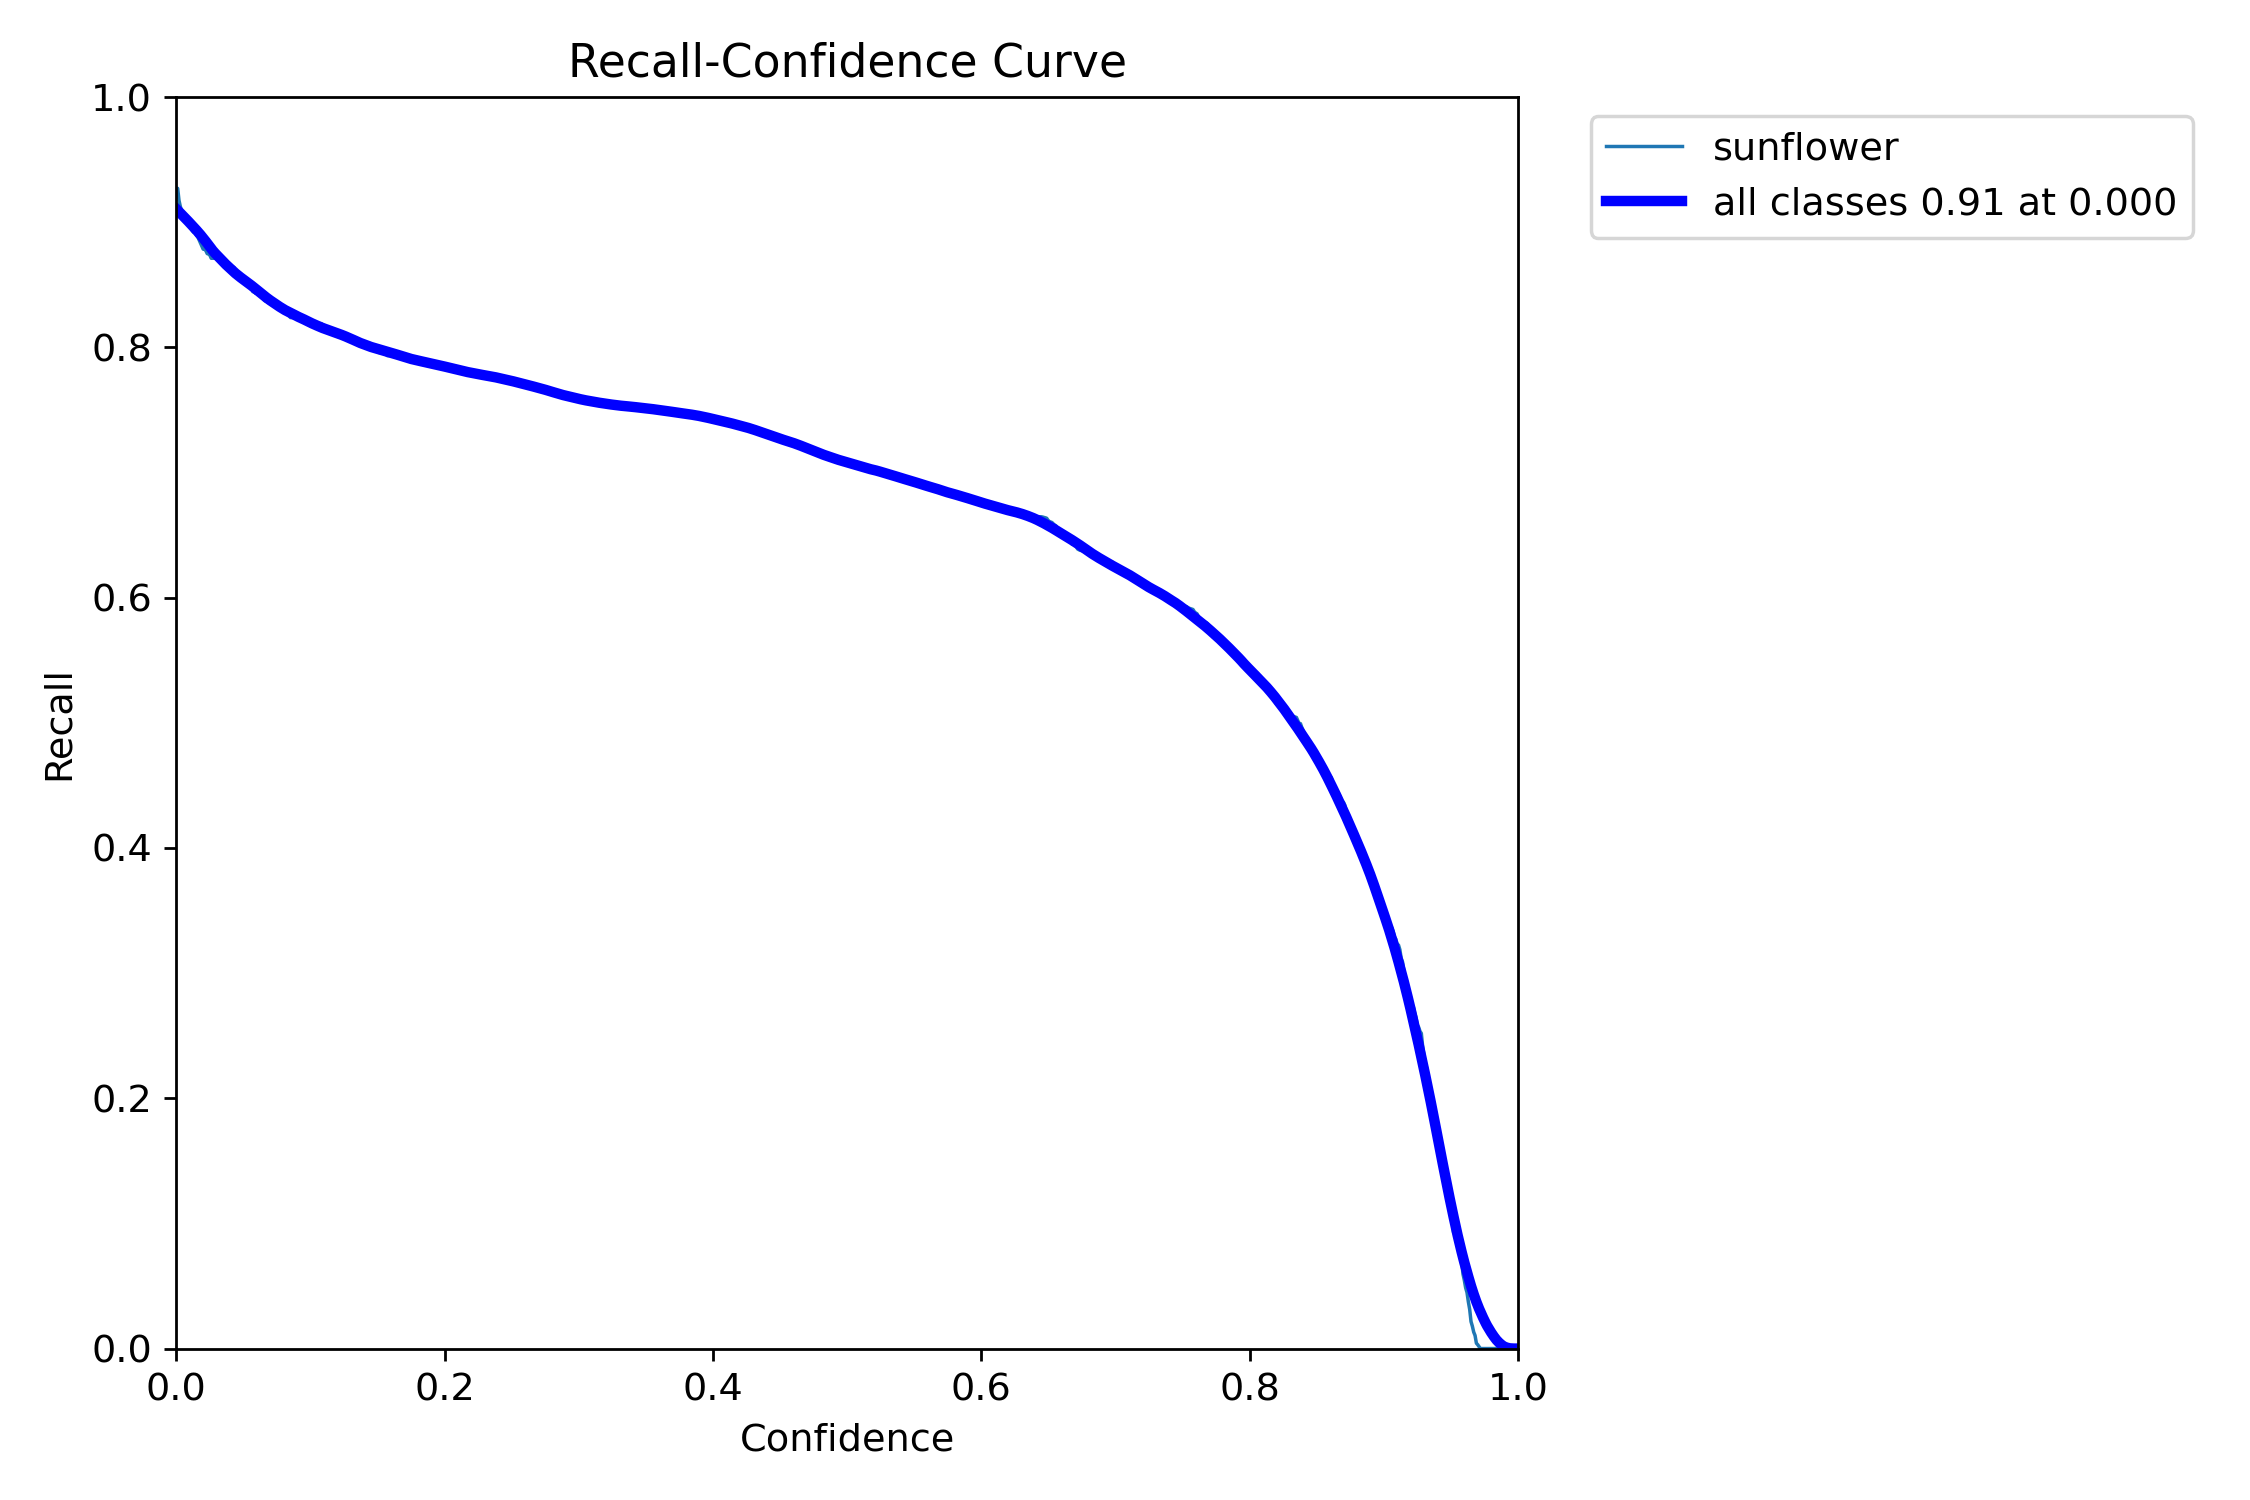

In [ ]:
from IPython.display import Image

Image(filename=f"/content/runs/detect/train5/R_curve.png", width=1000)

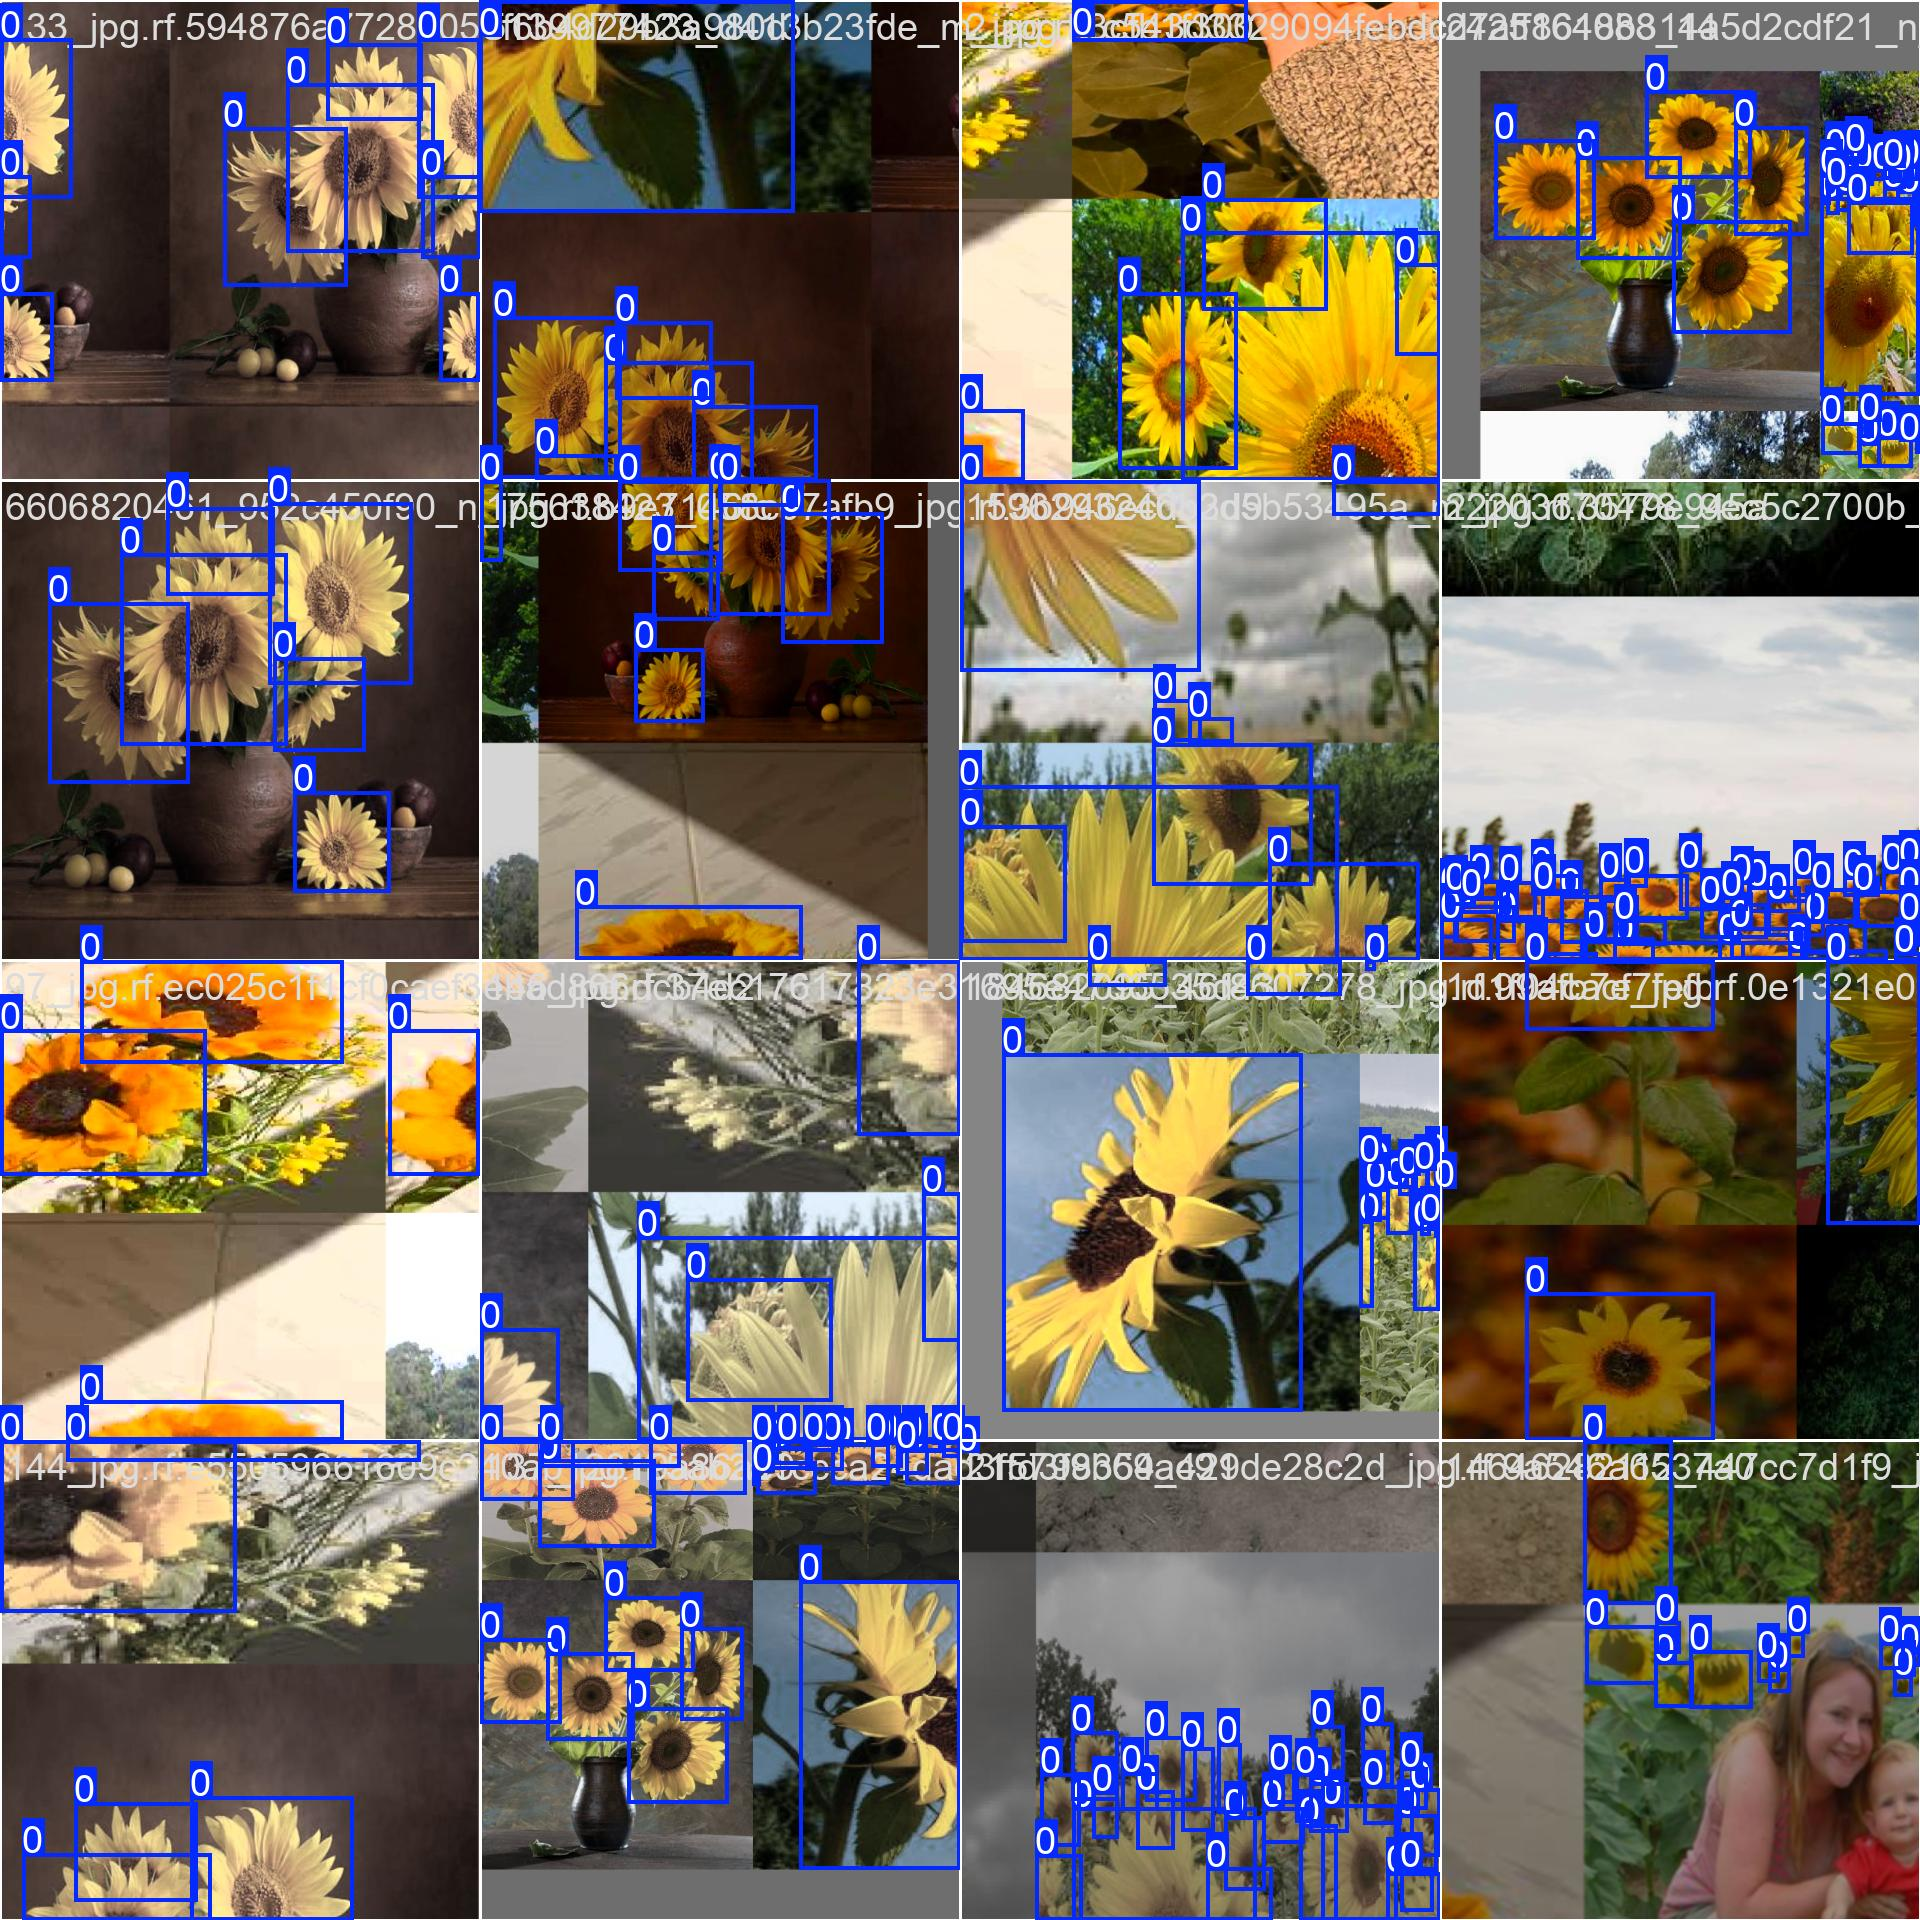

In [ ]:
from IPython.display import Image

Image(filename=f"/content/runs/detect/train5/train_batch1.jpg", width=1000)

Валидация данных

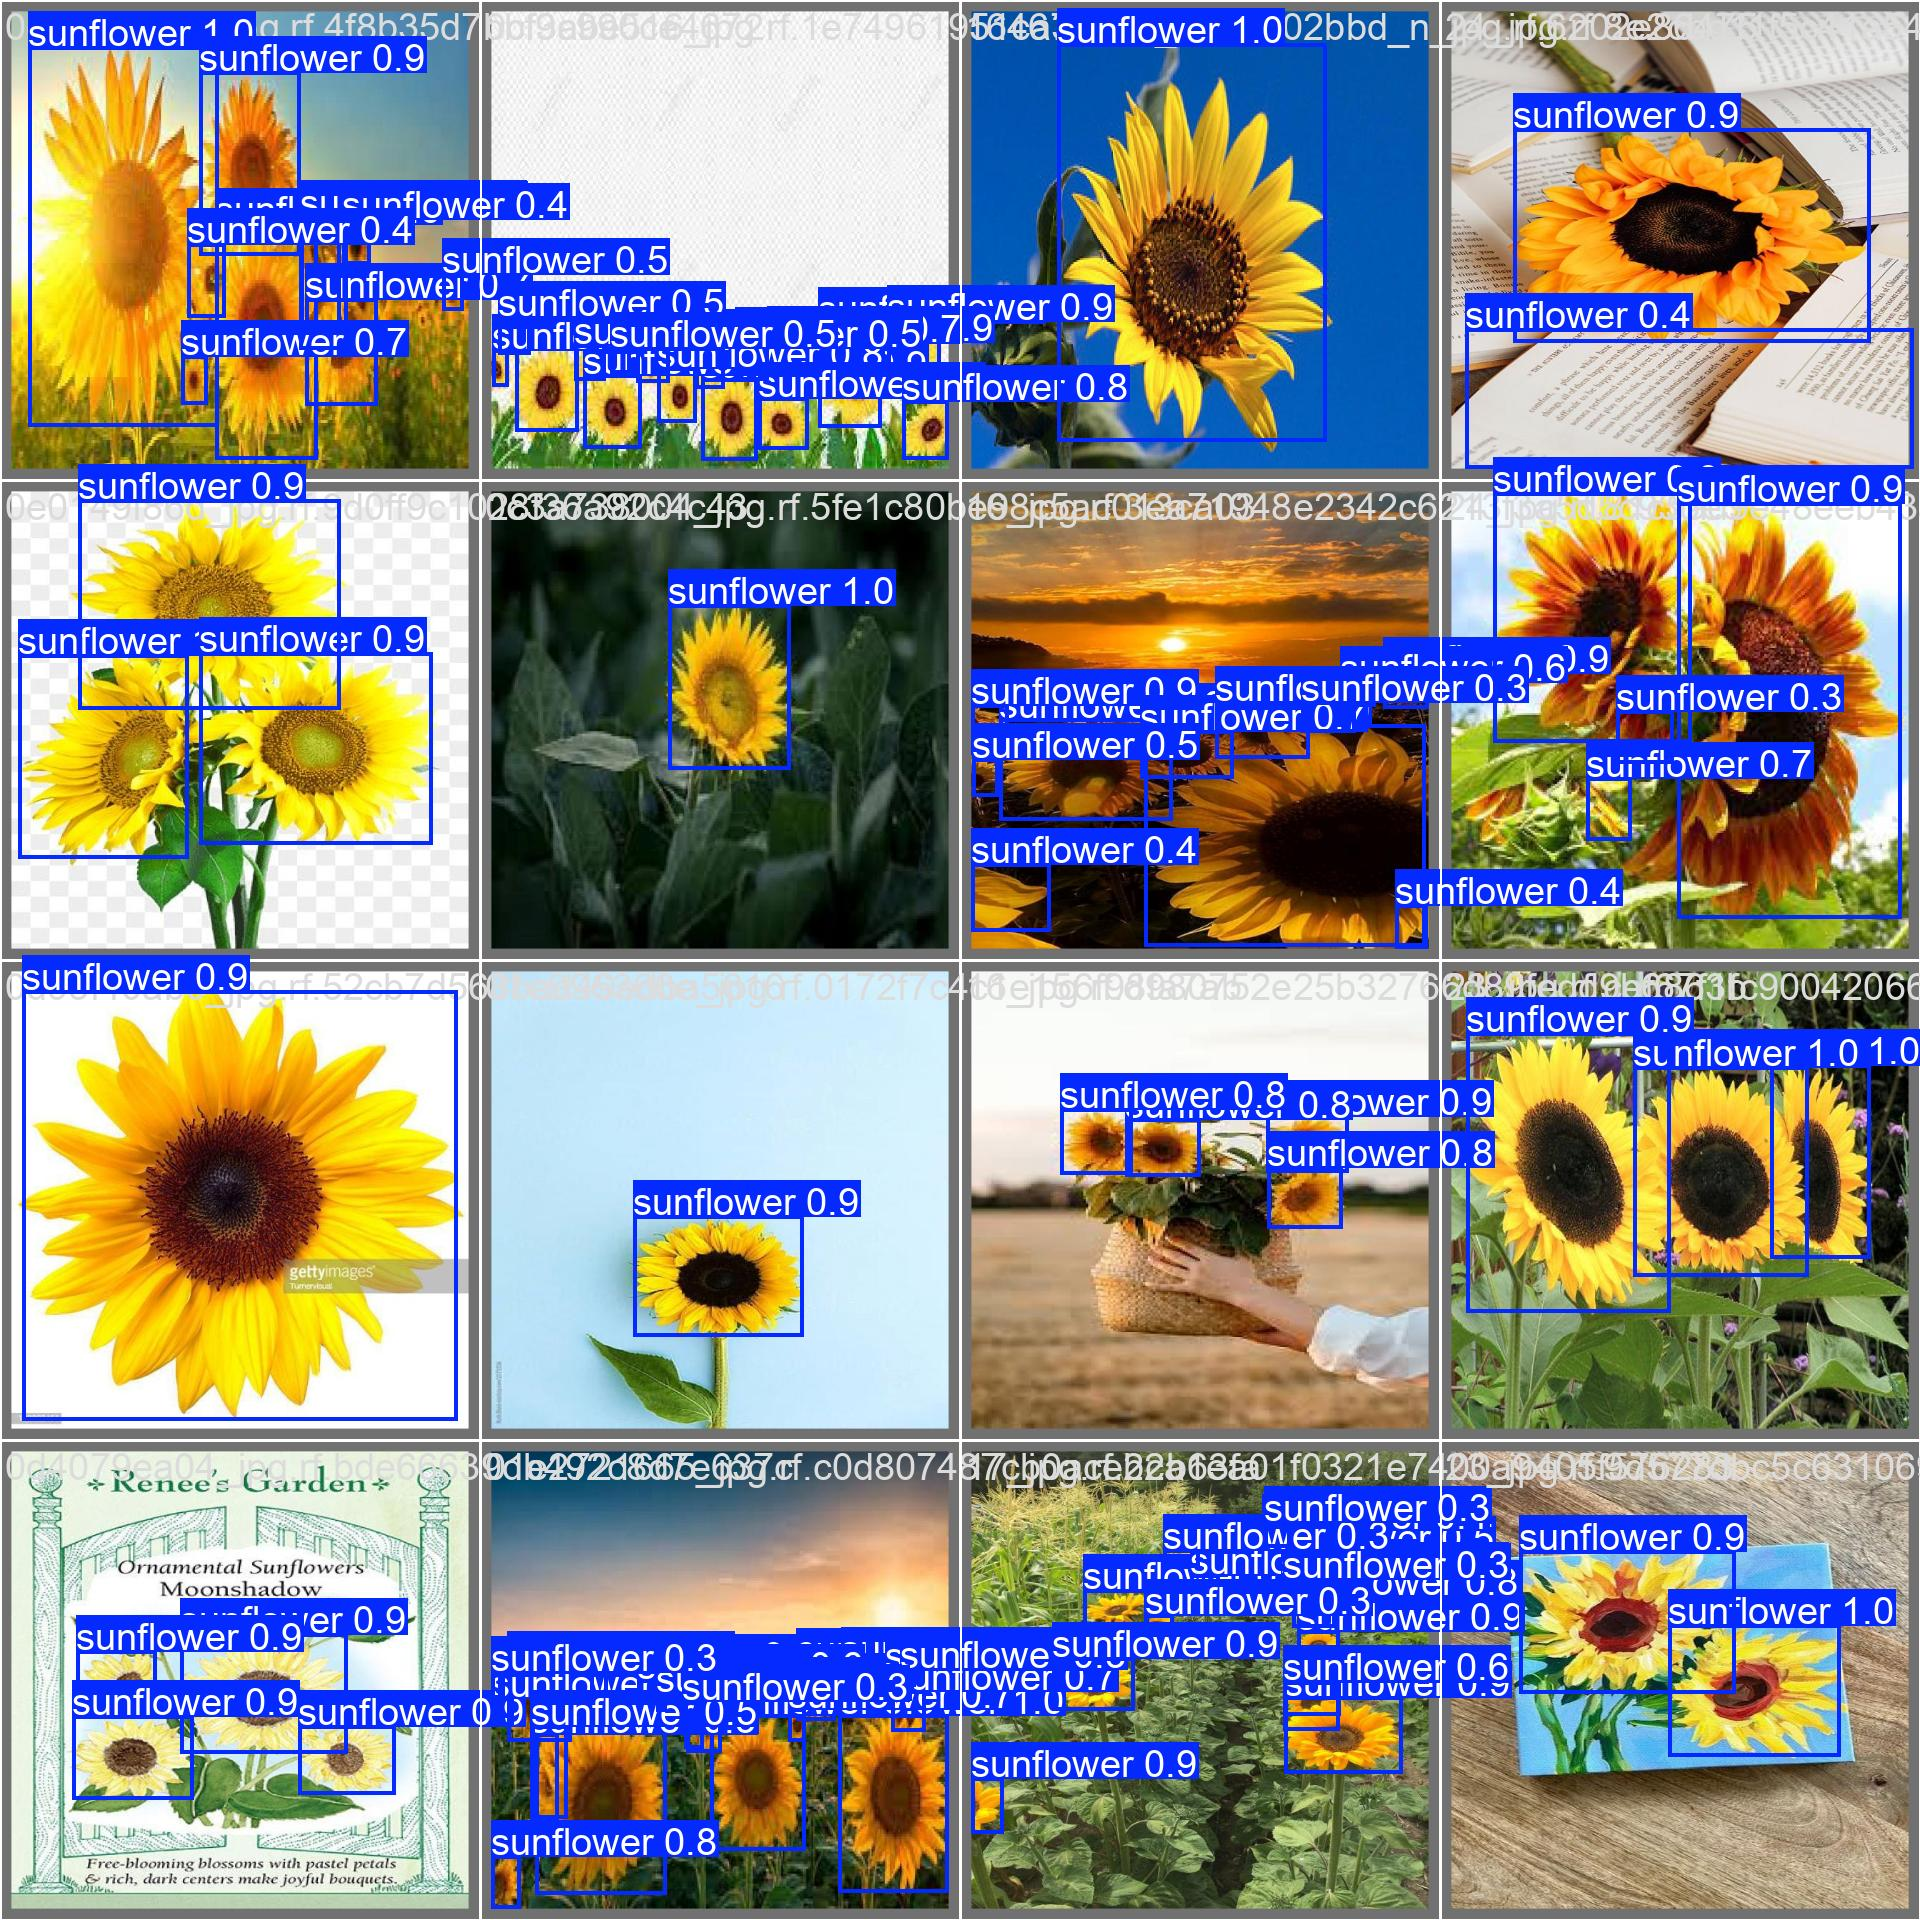

In [ ]:
from IPython.display import Image

Image(filename=f"/content/runs/detect/train3/val_batch2_pred.jpg", width=1000)